In [1]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("mlg-ulb/creditcardfraud")

print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/creditcardfraud


In [2]:
!pip install torch_geometric


import torch
from torch_geometric.data import Data
import numpy as np
import pandas as pd
from tqdm.notebook import tqdm


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.1/63.1 kB 1.4 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 16.5 MB/s eta 0:00:00a 0:00:01


In [4]:
#load the data set
df = pd.read_csv("/kaggle/input/creditcardfraud/creditcard.csv")

      
print("\ndf successfully loaded!")



df successfully loaded!


In [6]:
sample_df = df.head(10000).copy()

# Map original indices to new 0-based indices for the sample
node_mapping = {original_idx: new_idx for new_idx, original_idx in enumerate(sample_df.index)}
sample_df = sample_df.reset_index(drop=True)

# Use all features except Time and Class for node features
# We also scale the 'Amount' feature as it's on a different scale
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
sample_df['scaled_amount'] = scaler.fit_transform(sample_df['Amount'].values.reshape(-1, 1))
features_df = sample_df.drop(['Time', 'Class', 'Amount'], axis=1)

x = torch.tensor(features_df.values, dtype=torch.float)
y = torch.tensor(sample_df['Class'].values, dtype=torch.long)

# Create edge list: connect transactions that happen close in time
edge_list = []
time_diff_threshold = 2.0  # Connect transactions within 2 seconds

# Use a more efficient method to find edges
# Convert Time to a numpy array for faster operations
time_array = sample_df['Time'].to_numpy()

print("Building edges...")
# Iterate through each node
for i in tqdm(range(len(time_array))):
    # Find indices of nodes that are within the time threshold
    # We only look forward to avoid duplicate edges
    j_indices = np.where(
        (time_array > time_array[i]) &
        (time_array <= time_array[i] + time_diff_threshold)
    )[0]
    
    for j in j_indices:
        edge_list.append([i, j])

# Convert to the format PyTorch Geometric requires (COO format)
edge_index = torch.tensor(np.array(edge_list).T, dtype=torch.long)

# Create the graph data object
graph_data = Data(x=x, edge_index=edge_index, y=y)

# Add metadata for our model later
graph_data.num_classes = 2
graph_data.num_node_features = graph_data.x.shape[1]

print("\nGraph Data Object Created Successfully!")
print("======================================")
print(graph_data)
print(f"Number of nodes: {graph_data.num_nodes}")
print(f"Number of edges: {graph_data.num_edges}")
print(f"Number of fraudulent nodes in the sample: {torch.sum(graph_data.y).item()}")

Building edges...


  0%|          | 0/10000 [00:00<?, ?it/s]


Graph Data Object Created Successfully!
Data(x=[10000, 29], edge_index=[2, 28366], y=[10000], num_classes=2, num_node_features=29)
Number of nodes: 10000
Number of edges: 28366
Number of fraudulent nodes in the sample: 38


In [18]:
import torch.nn.functional as F
from torch_geometric.nn import SAGEConv, to_hetero
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_recall_fscore_support, roc_auc_score

# --- 1. Define the GNN Model (GraphSAGE) ---
class GraphSAGE_Fraud_Detector(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels):
        super().__init__()
        # Initialize two GraphSAGE convolutional layers
        self.conv1 = SAGEConv(in_channels, hidden_channels)
        self.conv2 = SAGEConv(hidden_channels, out_channels)

    def forward(self, x, edge_index):
        # Apply the first GraphSAGE layer followed by a ReLU activation function
        x = self.conv1(x, edge_index)
        x = x.relu()
        # Apply the second GraphSAGE layer
        x = self.conv2(x, edge_index)
        # We'll apply a log_softmax for the final output in the loss function
        return x

# --- 2. Prepare Data for Training ---
# Create masks to identify which nodes to use for training, validation, and testing
# This ensures we don't test our model on data it has already seen
num_nodes = graph_data.num_nodes
indices = torch.randperm(num_nodes)
train_size = int(0.7 * num_nodes)
val_size = int(0.15 * num_nodes)

train_mask = torch.zeros(num_nodes, dtype=torch.bool)
val_mask = torch.zeros(num_nodes, dtype=torch.bool)
test_mask = torch.zeros(num_nodes, dtype=torch.bool)

train_mask[indices[:train_size]] = True
val_mask[indices[train_size:train_size + val_size]] = True
test_mask[indices[train_size + val_size:]] = True

graph_data.train_mask = train_mask
graph_data.val_mask = val_mask
graph_data.test_mask = test_mask

# --- 3. Set Up the Training Process ---
# Initialize the model
model = GraphSAGE_Fraud_Detector(
    in_channels=graph_data.num_node_features,
    hidden_channels=64, # A common size for the hidden layer
    out_channels=graph_data.num_classes
)

# Use the Adam optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)

# Define the loss function. We use CrossEntropyLoss which is standard for classification.
# --- 1. Address Class Imbalance with a Weighted Loss Function ---

# Calculate the weight for each class based on its frequency
# The formula is: weight = total_samples / (num_classes * num_samples_of_class)
num_legit = len(graph_data.y[graph_data.y == 0])
num_fraud = len(graph_data.y[graph_data.y == 1])
total = num_legit + num_fraud

weight_legit = total / (2 * num_legit)
weight_fraud = total / (2 * num_fraud)

# Create a tensor of these weights
class_weights = torch.tensor([weight_legit, weight_fraud], dtype=torch.float)

print(f"Calculated Class Weights: Legit={weight_legit:.4f}, Fraud={weight_fraud:.4f}")

# Define the loss function with the calculated weights
criterion = torch.nn.CrossEntropyLoss(weight=class_weights)

# --- 4. Define Training and Evaluation Functions ---
def train():
    model.train()
    optimizer.zero_grad()
    # Perform a single forward pass
    out = model(graph_data.x, graph_data.edge_index)
    # Calculate the loss only on the training nodes
    loss = criterion(out[graph_data.train_mask], graph_data.y[graph_data.train_mask])
    loss.backward()
    optimizer.step()
    return loss.item()

def evaluate(mask):
    model.eval()
    with torch.no_grad():
        # Get model predictions
        out = model(graph_data.x, graph_data.edge_index)
        pred = out.argmax(dim=1)
        
        # Get the actual labels and predictions for the given mask
        true_labels = graph_data.y[mask]
        predicted_labels = pred[mask]
        
        # Calculate metrics. 'average="binary"' is crucial for fraud detection.
        precision, recall, f1, _ = precision_recall_fscore_support(
            true_labels, predicted_labels, average='binary', zero_division=0
        )
        
        # Calculate AUC score
        auc = roc_auc_score(true_labels, out[mask][:, 1].numpy())
        
    return precision, recall, f1, auc

# --- 5. Run the Training Loop ---
print("Starting GNN model training...")
for epoch in range(1, 101): # Train for 100 epochs
    loss = train()
    if epoch % 10 == 0:
        # Evaluate on the validation set every 10 epochs
        val_precision, val_recall, val_f1, val_auc = evaluate(graph_data.val_mask)
        print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}, Val Precision: {val_precision:.4f}, '
              f'Val Recall: {val_recall:.4f}, Val F1: {val_f1:.4f}, Val AUC: {val_auc:.4f}')

print("\nTraining complete!")

# --- 6. Final Evaluation on the Test Set ---
test_precision, test_recall, test_f1, test_auc = evaluate(graph_data.test_mask)
print("\nFinal Test Set Results:")
print("=======================")
print(f"Test Precision: {test_precision:.4f}")
print(f"Test Recall: {test_recall:.4f}")
print(f"Test F1-Score: {test_f1:.4f}")
print(f"Test AUC: {test_auc:.4f}")

Calculated Class Weights: Legit=0.5019, Fraud=131.5789
Starting GNN model training...
Epoch: 010, Loss: 0.0401, Val Precision: 0.3333, Val Recall: 1.0000, Val F1: 0.5000, Val AUC: 1.0000
Epoch: 020, Loss: 0.0080, Val Precision: 0.6667, Val Recall: 1.0000, Val F1: 0.8000, Val AUC: 1.0000
Epoch: 030, Loss: 0.0039, Val Precision: 0.6667, Val Recall: 1.0000, Val F1: 0.8000, Val AUC: 1.0000
Epoch: 040, Loss: 0.0027, Val Precision: 0.6667, Val Recall: 1.0000, Val F1: 0.8000, Val AUC: 1.0000
Epoch: 050, Loss: 0.0021, Val Precision: 0.6667, Val Recall: 1.0000, Val F1: 0.8000, Val AUC: 1.0000
Epoch: 060, Loss: 0.0019, Val Precision: 0.6667, Val Recall: 1.0000, Val F1: 0.8000, Val AUC: 1.0000
Epoch: 070, Loss: 0.0017, Val Precision: 0.6667, Val Recall: 1.0000, Val F1: 0.8000, Val AUC: 1.0000
Epoch: 080, Loss: 0.0016, Val Precision: 0.6667, Val Recall: 1.0000, Val F1: 0.8000, Val AUC: 1.0000
Epoch: 090, Loss: 0.0016, Val Precision: 0.6667, Val Recall: 1.0000, Val F1: 0.8000, Val AUC: 1.0000
Epoch

In [5]:
import torch
from torch_geometric.data import Data
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from scipy.spatial import KDTree
from tqdm.notebook import tqdm

# --- 1. Load and Prepare the FULL Dataset ---
# Assuming 'df' is your original full DataFrame
print("Preparing the full dataset...")

# Scale the 'Amount' and 'Time' features
scaler = StandardScaler()
df['scaled_amount'] = scaler.fit_transform(df['Amount'].values.reshape(-1, 1))
df['scaled_time'] = scaler.fit_transform(df['Time'].values.reshape(-1, 1))

# Define features and labels
features_df = df.drop(['Time', 'Class', 'Amount'], axis=1)
x = torch.tensor(features_df.values, dtype=torch.float)
y = torch.tensor(df['Class'].values, dtype=torch.long)


# --- 2. Optimized Edge Creation using K-D Trees ---
print("Building edges for the full graph... (This may take a few minutes)")

# Use a subset of important features to define "similarity" between transactions
# We'll use scaled_time and a few key anonymized features
search_features = df[['scaled_time', 'V10', 'V12', 'V14', 'V17']].to_numpy()

# Build a K-D Tree for efficient nearest neighbor search
tree = KDTree(search_features)

# Query the tree to find the 5 nearest neighbors for each transaction
# We use a small radius 'r' to only connect very close transactions
# This radius is a hyperparameter you can tune
radius = 0.1 
edge_list = tree.query_ball_tree(tree, r=radius)

# Flatten the list of lists into the COO format for PyG
row = [i for i, neighbors in enumerate(edge_list) for _ in neighbors]
col = [neighbor for neighbors in edge_list for neighbor in neighbors]

# Remove self-loops
self_loops = [i for i, (r, c) in enumerate(zip(row, col)) if r == c]
keep_indices = [i for i in range(len(row)) if i not in self_loops]

row = np.array(row)[keep_indices]
col = np.array(col)[keep_indices]

edge_index = torch.tensor([row, col], dtype=torch.long)


# --- 3. Create the Final Graph Data Object ---
full_graph_data = Data(x=x, edge_index=edge_index, y=y)
full_graph_data.num_classes = 2
full_graph_data.num_node_features = full_graph_data.x.shape[1]

print("\nFull Graph Data Object Created Successfully!")
print("==========================================")
print(full_graph_data)
print(f"Number of nodes: {full_graph_data.num_nodes}")
print(f"Number of edges: {full_graph_data.num_edges}")
print(f"Number of fraudulent nodes: {torch.sum(full_graph_data.y).item()}")

Preparing the full dataset...
Building edges for the full graph... (This may take a few minutes)

Full Graph Data Object Created Successfully!
Data(x=[284807, 30], edge_index=[2, 422520], y=[284807], num_classes=2, num_node_features=30)
Number of nodes: 284807
Number of edges: 422520
Number of fraudulent nodes: 492


/tmp/ipykernel_36/2351747423.py:51: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /pytorch/torch/csrc/utils/tensor_new.cpp:254.)
  edge_index = torch.tensor([row, col], dtype=torch.long)


Starting FINAL GNN model training on the full graph...
Epoch: 010, Loss: 0.0197, Val Precision: 0.0000, Val Recall: 0.0000, Val F1: 0.0000, Val AUC: 0.8208
Epoch: 020, Loss: 0.0053, Val Precision: 0.0000, Val Recall: 0.0000, Val F1: 0.0000, Val AUC: 0.9125
Epoch: 030, Loss: 0.0041, Val Precision: 0.7636, Val Recall: 0.5600, Val F1: 0.6462, Val AUC: 0.9761
Epoch: 040, Loss: 0.0035, Val Precision: 0.7273, Val Recall: 0.7467, Val F1: 0.7368, Val AUC: 0.9890
Epoch: 050, Loss: 0.0034, Val Precision: 0.7125, Val Recall: 0.7600, Val F1: 0.7355, Val AUC: 0.9911
Epoch: 060, Loss: 0.0033, Val Precision: 0.7215, Val Recall: 0.7600, Val F1: 0.7403, Val AUC: 0.9910
Epoch: 070, Loss: 0.0034, Val Precision: 0.7273, Val Recall: 0.7467, Val F1: 0.7368, Val AUC: 0.9907
Epoch: 080, Loss: 0.0035, Val Precision: 0.7308, Val Recall: 0.7600, Val F1: 0.7451, Val AUC: 0.9904
Epoch: 090, Loss: 0.0035, Val Precision: 0.7308, Val Recall: 0.7600, Val F1: 0.7451, Val AUC: 0.9894
Epoch: 100, Loss: 0.0035, Val Precis

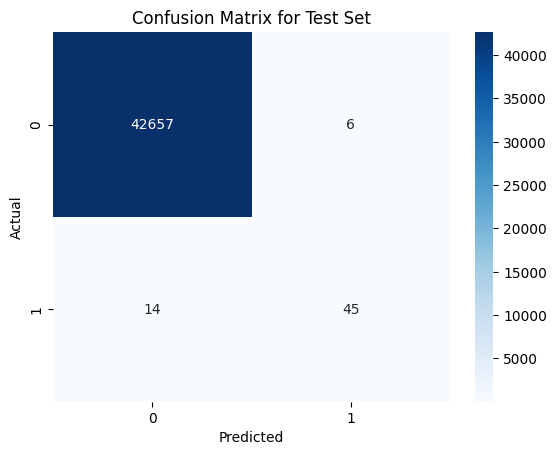

In [6]:
import torch
import torch.nn.functional as F
from torch_geometric.nn import SAGEConv
from torch_geometric.data import Data
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_recall_fscore_support, roc_auc_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# --- 1. Define the GNN Model (GraphSAGE) - Same as before ---
class GraphSAGE_Fraud_Detector(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels):
        super().__init__()
        self.conv1 = SAGEConv(in_channels, hidden_channels)
        self.conv2 = SAGEConv(hidden_channels, out_channels)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = x.relu()
        x = self.conv2(x, edge_index)
        return x

# --- 2. Prepare the FULL Graph Data for Training ---
# Create new masks for our full_graph_data object
num_nodes = full_graph_data.num_nodes
indices = torch.randperm(num_nodes)
train_size = int(0.7 * num_nodes)
val_size = int(0.15 * num_nodes)

train_mask = torch.zeros(num_nodes, dtype=torch.bool)
val_mask = torch.zeros(num_nodes, dtype=torch.bool)
test_mask = torch.zeros(num_nodes, dtype=torch.bool)

train_mask[indices[:train_size]] = True
val_mask[indices[train_size:train_size + val_size]] = True
test_mask[indices[train_size + val_size:]] = True

full_graph_data.train_mask = train_mask
full_graph_data.val_mask = val_mask
full_graph_data.test_mask = test_mask

# --- 3. Set Up the Training Process ---
# Initialize the model for the full graph
model = GraphSAGE_Fraud_Detector(
    in_channels=full_graph_data.num_node_features,
    hidden_channels=64,
    out_channels=full_graph_data.num_classes
)

optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)
criterion = torch.nn.CrossEntropyLoss()

# --- 4. Define Training and Evaluation Functions - Same as before ---
def train():
    model.train()
    optimizer.zero_grad()
    out = model(full_graph_data.x, full_graph_data.edge_index)
    loss = criterion(out[full_graph_data.train_mask], full_graph_data.y[full_graph_data.train_mask])
    loss.backward()
    optimizer.step()
    return loss.item()

def evaluate(mask):
    model.eval()
    with torch.no_grad():
        out = model(full_graph_data.x, full_graph_data.edge_index)
        pred = out.argmax(dim=1)
        true_labels = full_graph_data.y[mask]
        predicted_labels = pred[mask]
        
        precision, recall, f1, _ = precision_recall_fscore_support(
            true_labels, predicted_labels, average='binary', zero_division=0
        )
        auc = roc_auc_score(true_labels, out[mask][:, 1].cpu().numpy())
        
    return precision, recall, f1, auc, true_labels, predicted_labels

# --- 5. Run the Training Loop ---
print("Starting FINAL GNN model training on the full graph...")
for epoch in range(1, 101): # Train for 100 epochs
    loss = train()
    if epoch % 10 == 0:
        val_precision, val_recall, val_f1, val_auc, _, _ = evaluate(full_graph_data.val_mask)
        print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}, Val Precision: {val_precision:.4f}, '
              f'Val Recall: {val_recall:.4f}, Val F1: {val_f1:.4f}, Val AUC: {val_auc:.4f}')

print("\nFinal training complete!")

# --- 6. Final Evaluation on the Full Test Set ---
test_precision, test_recall, test_f1, test_auc, true_test, pred_test = evaluate(full_graph_data.test_mask)
print("\n--- FINAL MODEL PERFORMANCE ---")
print("================================")
print(f"Test Precision: {test_precision:.4f}")
print(f"Test Recall: {test_recall:.4f}")
print(f"Test F1-Score: {test_f1:.4f}")
print(f"Test AUC: {test_auc:.4f}")

# Optional: Visualize the confusion matrix
cm = confusion_matrix(true_test.cpu(), pred_test.cpu())
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix for Test Set')
plt.show()

In [11]:
print ("\nProject Completed by Ankur Mishra COPYRIGHT(c)")


Project Completed by Ankur Mishra COPYRIGHT(c)


In [1]:
import pickle

# --- Save the Trained GNN Model ---
# The state_dict contains all the learned weights and biases
torch.save(model.state_dict(), 'fraud_gnn_model.pth')

# --- Save the Scaler ---
# The scaler is essential to process new, incoming data in the same way
with open('scaler.pkl', 'wb') as f:
    pickle.dump(scaler, f)

# --- Save the K-D Tree training data ---
# We need the data the tree was built on to find neighbors for new transactions
np.save('kdtree_features.npy', search_features)

print("Model, scaler, and K-D tree data have been saved successfully!")

NameError: name 'torch' is not defined

In [9]:
import pickle

# --- CORRECTED ARTIFACT SAVING ---

# Create and fit a scaler specifically for Amount
amount_scaler = StandardScaler()
df['scaled_amount'] = amount_scaler.fit_transform(df['Amount'].values.reshape(-1, 1))

# Create and fit a separate scaler specifically for Time
time_scaler = StandardScaler()
df['scaled_time'] = time_scaler.fit_transform(df['Time'].values.reshape(-1, 1))

# --- Save the Trained GNN Model (same as before) ---
torch.save(model.state_dict(), 'fraud_gnn_model.pth')

# --- Save the TWO new Scalers ---
with open('amount_scaler.pkl', 'wb') as f:
    pickle.dump(amount_scaler, f)
    
with open('time_scaler.pkl', 'wb') as f:
    pickle.dump(time_scaler, f)

# --- Save the K-D Tree training data (same as before) ---
# Ensure 'search_features' is defined from your graph creation cell
np.save('kdtree_features.npy', search_features)

print("Model, TWO scalers (amount_scaler.pkl, time_scaler.pkl), and K-D tree data have been saved successfully!")

Model, TWO scalers (amount_scaler.pkl, time_scaler.pkl), and K-D tree data have been saved successfully!


In [11]:
import pickle
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler

# --- TRAIN AND SAVE THE FEATURE PREDICTION MODEL ---

# 1. Define our simple inputs (X) and complex outputs (y)
X = df[['Time', 'Amount']]
y = df.loc[:, 'V1':'V28'] # This selects all columns from V1 to V28

# 2. It's good practice to scale the inputs
feature_scaler = StandardScaler()
X_scaled = feature_scaler.fit_transform(X)

# 3. Initialize and train the RandomForest model
# n_estimators=50 is a good starting point for speed and performance
# n_jobs=-1 will use all available CPU cores to speed up training
print("Training the feature prediction model... (This may take a few minutes)")
feature_predictor_model = RandomForestRegressor(n_estimators=50, random_state=42, n_jobs=-1)
feature_predictor_model.fit(X_scaled, y)
print("Feature prediction model trained successfully!")

# 4. Save the new model and its scaler
with open('feature_predictor_model.pkl', 'wb') as f:
    pickle.dump(feature_predictor_model, f)

with open('feature_scaler.pkl', 'wb') as f:
    pickle.dump(feature_scaler, f)
    
print("feature_predictor_model.pkl and feature_scaler.pkl have been saved!")

Training the feature prediction model... (This may take a few minutes)
Feature prediction model trained successfully!
feature_predictor_model.pkl and feature_scaler.pkl have been saved!


In [12]:
from IPython.display import FileLink

print("Click the links below to download your files:")

# Create a direct download link for the feature predictor model
display(FileLink('feature_predictor_model.pkl'))

# Create a link for its scaler as well
display(FileLink('feature_scaler.pkl'))

Click the links below to download your files:


/kaggle/working/feature_predictor_model.pkl

/kaggle/working/feature_scaler.pkl